In [1]:
import numpy as np
import rasterio
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV



In [2]:
# Load the predictor variables
with rasterio.open(r'data\aggregated_over_years_model_input\sm_min_pro.tif') as src:
    sm_min = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\lai_min_pro.tif') as src:
    lai_min = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\lai_sum_mean_pro.tif') as src:
    lai_sum_mean = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\t_max_pro.tif') as src:
    t_max = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\index_max_pro.tif') as src:
    index_max = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\index_severity_pro.tif') as src:
    index_severity = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\sand_pro.tif') as src:
    sand = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\clay_pro.tif') as src:
    clay = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\soc_pro.tif') as src:
    soc = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\silt_pro.tif') as src:
    silt = src.read(1)  # Read the first band



# Load the response variable
with rasterio.open(r'data\dead\deadwood.tif') as src:
    deadwood = src.read(1)  # Read the first band

In [10]:
import numpy as np

# Replace zeros with NaNs in specific variables
soc = np.where(soc == 0, np.nan, soc)
sand = np.where(sand == 0, np.nan, sand)
silt = np.where(silt == 0, np.nan, silt)
clay = np.where(clay == 0, np.nan, clay)

# Flatten the arrays to 1D
sm_min_flat = sm_min.flatten()
lai_min_flat = lai_min.flatten()
lai_sum_mean_flat = lai_sum_mean.flatten()
t_max_flat = t_max.flatten()
sand_flat = sand.flatten()
clay_flat = clay.flatten()
soc_flat = soc.flatten()
silt_flat = silt.flatten()
deadwood_flat = deadwood.flatten()

# Stack predictor variables into a single array
X = np.column_stack((sm_min_flat, lai_min_flat, lai_sum_mean_flat, t_max_flat, sand_flat, clay_flat, soc_flat, silt_flat))
y = deadwood_flat

# Remove rows with NAs and entries with -32768.0 in deadwood_flat
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y) & (y != -32768.0)
X_clean = X[mask]
y_clean = y[mask]

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=2)

In [11]:
# Best parameters obtained from grid search
best_params = {
    'ccp_alpha': 0.01,
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 2000
}

# Initialize the RandomForestRegressor with the best parameters
rf = RandomForestRegressor(
    random_state=123,
    oob_score=True,
    ccp_alpha=best_params['ccp_alpha'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators']
)

# Now you can fit this model to your training data
rf.fit(X_train, y_train)

# Optionally, evaluate using the Out-of-Bag score
print("OOB Score: {:.3f}".format(rf.oob_score_))

# Predict using the test set, if desired
y_pred = rf.predict(X_test)


OOB Score: 0.589


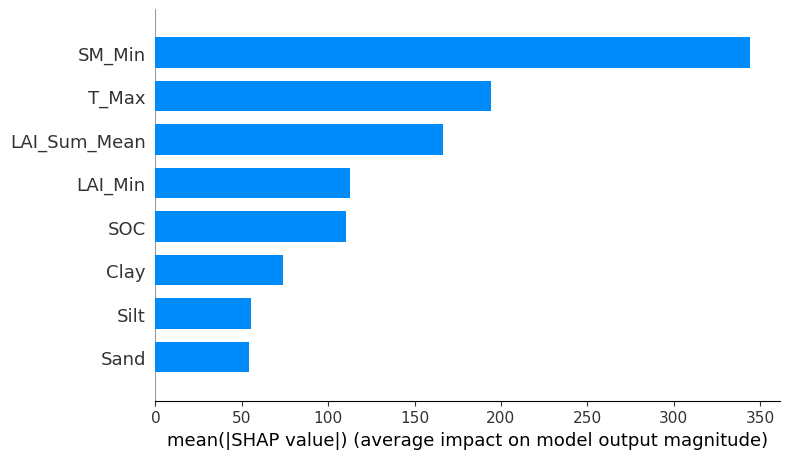

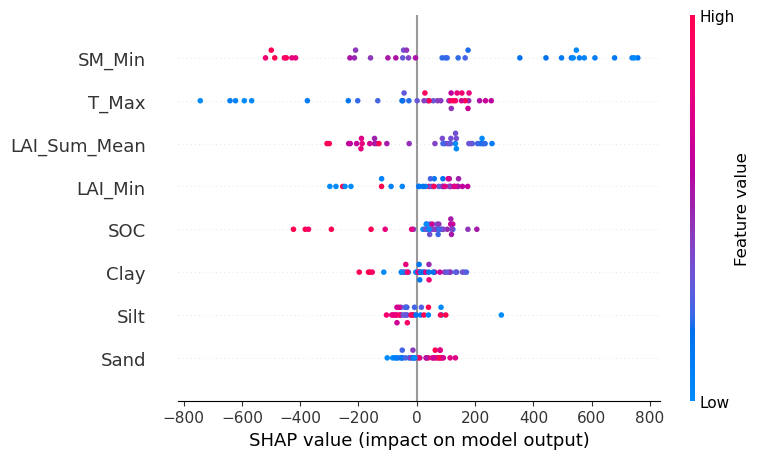

In [15]:
import shap

# Suppose your features have these names
feature_names = ['SM_Min', 'LAI_Min', 'LAI_Sum_Mean', 'T_Max', 'Sand', 'Clay', 'SOC', 'Silt']


# Initialize the SHAP explainer object with the random forest model
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values - here we use a subset of the test data for speed
shap_values = explainer.shap_values(X_test)

# Plot the SHAP values - summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names)

# Standard SHAP summary plot (not just the bar plot)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)



# colinearity / correlation

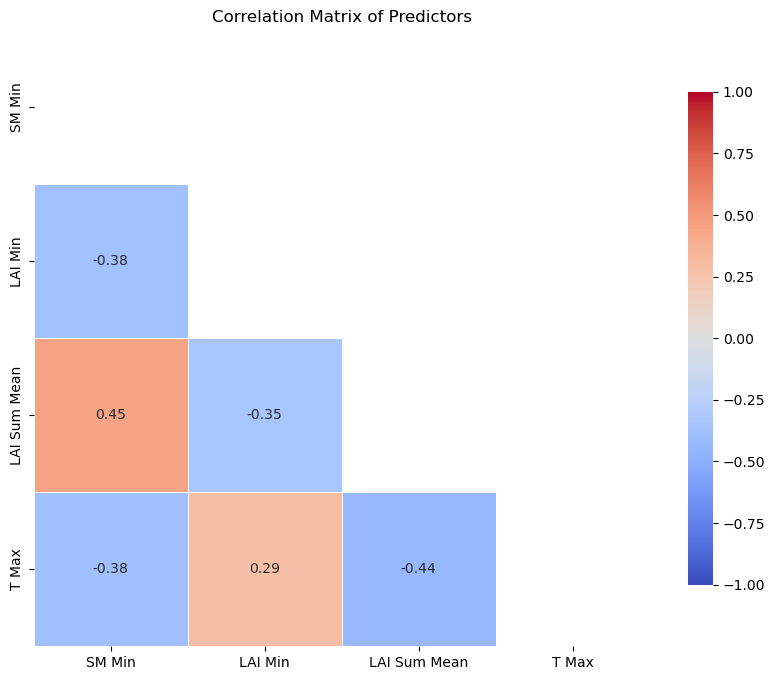

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_clean is a numpy array with your cleaned predictors
# Create a DataFrame for better handling with columns named according to your predictors
df_predictors = pd.DataFrame(X_clean, columns=['SM Min', 'LAI Min', 'LAI Sum Mean', 'T Max'])

# Compute the correlation matrix
corr_matrix = df_predictors.corr()

# Generate a mask for the upper triangle (optional, for aesthetics)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            vmax=1, vmin=-1, square=True, linewidths=.5, cbar_kws={"shrink": .8})

# Add titles and labels for clarity
plt.title('Correlation Matrix of Predictors')
plt.show()
